<a href="https://colab.research.google.com/github/Ralinthip/Palmistry/blob/main/Profinal_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

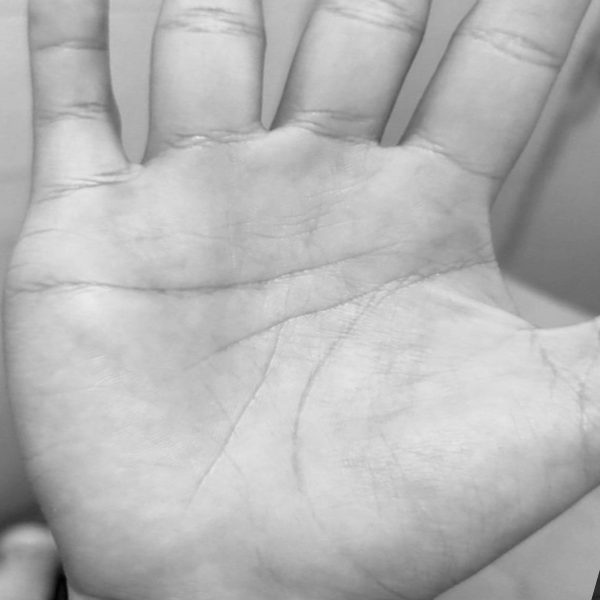

Perimeter of heart line: 1149.65
Heart Line: ดีมาก
Perimeter of head line: 670.98
Head Line: ดี
Perimeter of life line: 567.61
Life Line: แย่


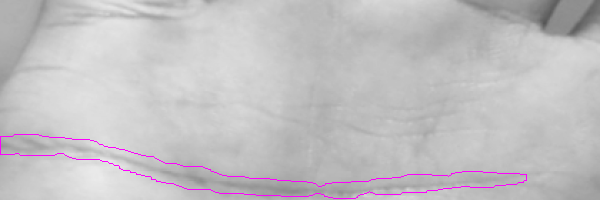

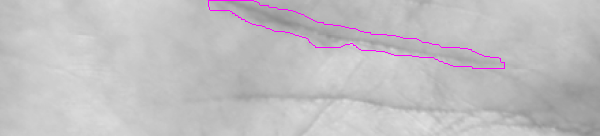

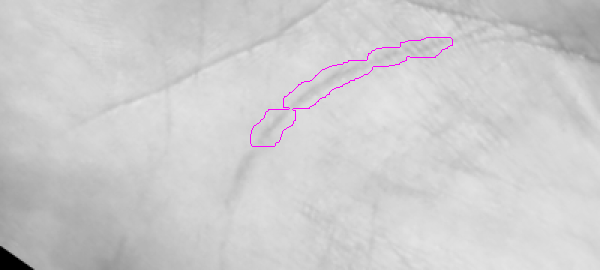

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import imutils
import numpy as np
from matplotlib import pyplot as plt

# Load palmprint image
palm_image = cv2.imread('palm10.jpg')

# เพิ่มความเข้มของภาพ
enhanced_image = cv2.convertScaleAbs(palm_image, alpha=1.5, beta=-50)

# Convert image to grayscale
gray = cv2.cvtColor(enhanced_image, cv2.COLOR_BGR2GRAY)

# Resize image to 600x600
gray = cv2.resize(gray, (600, 600))
cv2_imshow(gray)

# Copy the grayscale image for heart, head, and life regions
heart = gray.copy()
head = gray.copy()
life = gray.copy()


# Rotate the 'heart' region
center = (heart.shape[1] // 2, heart.shape[0] // 2)
angle = -10
scale = 1.0
rotation_matrix = cv2.getRotationMatrix2D(center, angle, scale)
rotated_image = cv2.warpAffine(heart, rotation_matrix, (heart.shape[1], heart.shape[0]))

# Define ROI for heart line (Adjust coordinates and size as needed)
x, y, w, h = 25, 140, 420, 140
heart = rotated_image[y:y+h, x:x+w]

# Rotate the 'head' region
center = (head.shape[1] // 2, head.shape[0] // 2)
angle = -25
scale = 1.0
rotation_matrix = cv2.getRotationMatrix2D(center, angle, scale)
rotated_image = cv2.warpAffine(head, rotation_matrix, (head.shape[1], head.shape[0]))

# Define ROI for head line
x, y, w, h = 30, 240, 440, 100
head = rotated_image[y:y+h, x:x+w]

# Rotate the 'life' region
angle = -35
scale = 1.0
rotation_matrix = cv2.getRotationMatrix2D(center, angle, scale)
rotated_image = cv2.warpAffine(life, rotation_matrix, (life.shape[1], life.shape[0]))

# Define ROI for life line
x, y, w, h = 40, 320, 400, 180
life = rotated_image[y:y+h, x:x+w]

#ปรับขนาด
heart = imutils.resize(heart, width=600)
head = imutils.resize(head, width=600)
life = imutils.resize(life, width=600)

# Apply Gaussian Blur to each region
blurred_heart = cv2.GaussianBlur(heart, (35, 35), 0)
blurred_head = cv2.GaussianBlur(head, (35, 35), 0)
blurred_life = cv2.GaussianBlur(life, (35, 35), 0)
#cv2_imshow(blurred_heart)
#cv2_imshow(blurred_head)
#cv2_imshow(blurred_life)


# Apply adaptive thresholding to each region
adaptive_thresh_heart = cv2.adaptiveThreshold(
    blurred_heart, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 29, 2
)
#cv2_imshow(adaptive_thresh_heart)
adaptive_thresh_head = cv2.adaptiveThreshold(
    blurred_head, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 29, 2
)
#cv2_imshow(adaptive_thresh_head)
adaptive_thresh_life = cv2.adaptiveThreshold(
    blurred_life, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 29, 2
)
#cv2_imshow(adaptive_thresh_life)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21,7))
dilated_heart = cv2.dilate(adaptive_thresh_heart, kernel, iterations=1)
dilated_head = cv2.dilate(adaptive_thresh_head, kernel, iterations=1)
dilated_life = cv2.dilate(adaptive_thresh_life, kernel, iterations=1)

# Apply morphological transformations (opening and closing)
kernel = np.ones((15, 15), np.uint64)

# Morphological Opening (removes small noise)
morph_heart = cv2.morphologyEx(dilated_heart, cv2.MORPH_OPEN, kernel)
morph_head = cv2.morphologyEx(dilated_head, cv2.MORPH_OPEN, kernel)
morph_life = cv2.morphologyEx(dilated_life, cv2.MORPH_OPEN, kernel)
#cv2_imshow(morph_heart)
#cv2_imshow(morph_head)
#cv2_imshow(morph_life)


# Function to calculate the length (perimeter) of a contour
def contour_length(contour):
    return cv2.arcLength(contour, True)

# Function to find the longest contour in an image and return its perimeter and contour
def get_longest_contour(thresh_image):
    contours, _ = cv2.findContours(thresh_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    sorted_contours = sorted(contours, key=contour_length, reverse=True)[:1]
    longest_contour = sorted_contours[0] if sorted_contours else None
    perimeter = contour_length(longest_contour) if longest_contour is not None else 0
    return perimeter, longest_contour

# Get the longest contour and perimeter for heart, head, and life regions
perimeter_heart, longest_contour_heart = get_longest_contour(dilated_heart)
perimeter_head, longest_contour_head = get_longest_contour(dilated_head)
perimeter_life, longest_contour_life = get_longest_contour(dilated_life)

# Draw the longest contours in purple
if longest_contour_heart is not None:
    heart = cv2.cvtColor(heart, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(heart, [longest_contour_heart], -1, (255, 0, 255), 1)

if longest_contour_head is not None:
    head = cv2.cvtColor(head, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(head, [longest_contour_head], -1, (255, 0, 255), 1)

if longest_contour_life is not None:
    life = cv2.cvtColor(life, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(life, [longest_contour_life], -1, (255, 0, 255), 1)

# Function to classify based on perimeter
def classify_perimeter(perimeter, thresholds):
    if perimeter < thresholds[0]:
        return "แย่"
    elif perimeter < thresholds[1]:
        return "ดี"
    else:
        return "ดีมาก"

# Define thresholds for each line
heart_thresholds = [593.66, 905.2625]
head_thresholds = [624.665, 865.535]
life_thresholds = [591.495, 890.81]

# Classify each line based on the thresholds
heart_result = classify_perimeter(perimeter_heart, heart_thresholds)
head_result = classify_perimeter(perimeter_head, head_thresholds)
life_result = classify_perimeter(perimeter_life, life_thresholds)

# Print the calculated perimeters
print(f"Perimeter of heart line: {perimeter_heart:.2f}")
print(f"Heart Line: {heart_result}")
print(f"Perimeter of head line: {perimeter_head:.2f}")
print(f"Head Line: {head_result}")
print(f"Perimeter of life line: {perimeter_life:.2f}")
print(f"Life Line: {life_result}")

# Display the original and cropped images with drawn contours
cv2_imshow(heart)
cv2_imshow(head)
cv2_imshow(life)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Processing image 1


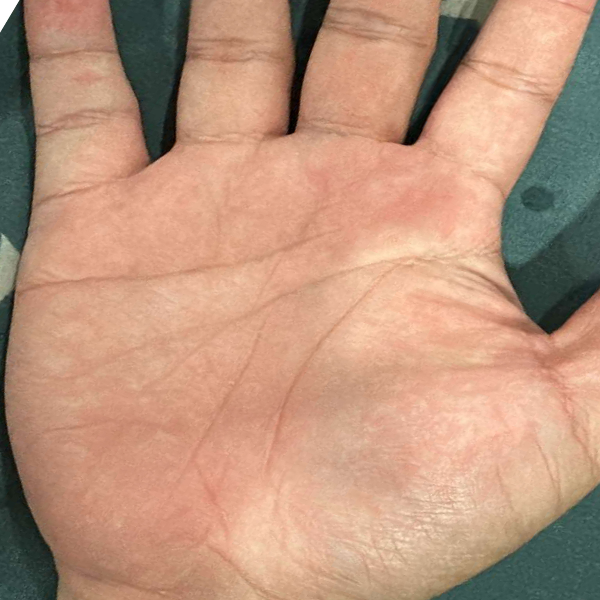

Heart line perimeter: 1057.12
Heart ROI Image:


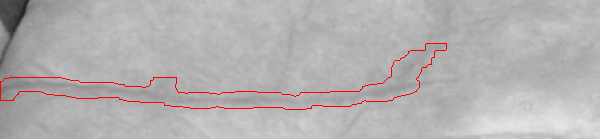

Head line perimeter: 858.53
Head ROI Image:


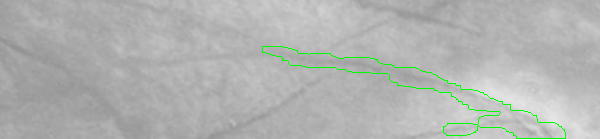

Life line perimeter: 737.02
Life ROI Image:


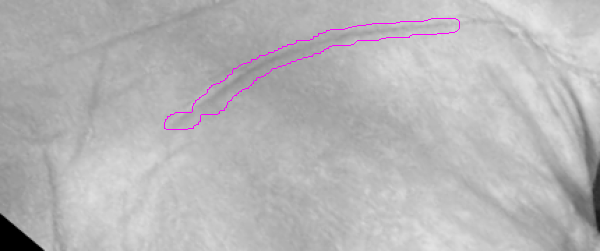

Processing image 2


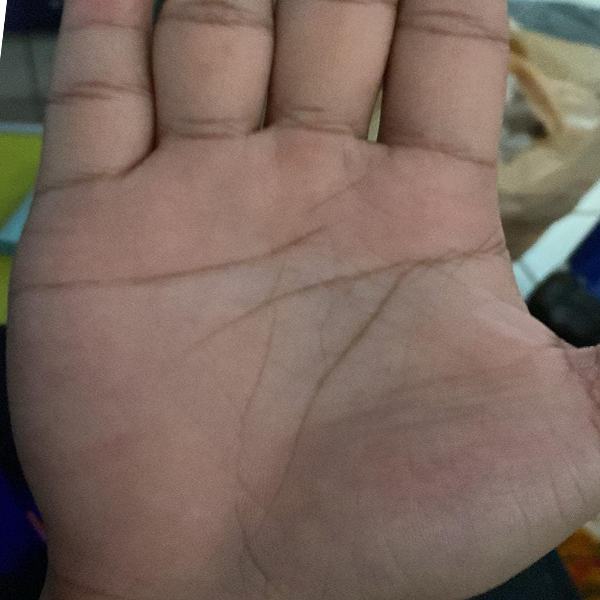

Heart line perimeter: 689.24
Heart ROI Image:


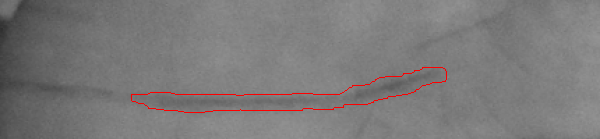

Head line perimeter: 663.56
Head ROI Image:


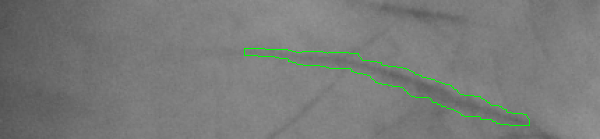

Life line perimeter: 1123.43
Life ROI Image:


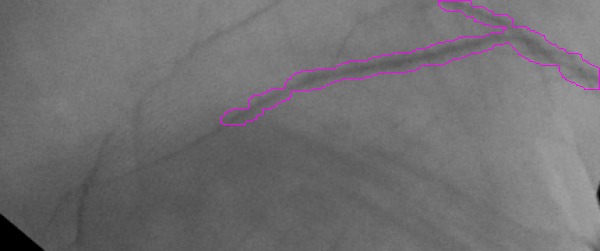

Processing image 3


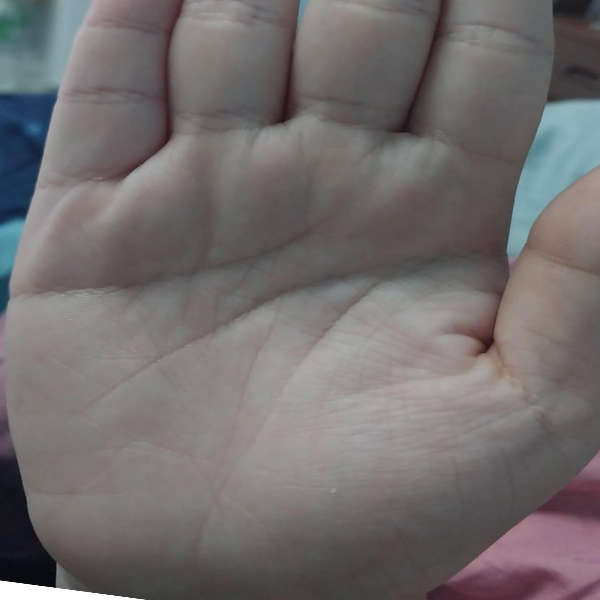

Heart line perimeter: 967.46
Heart ROI Image:


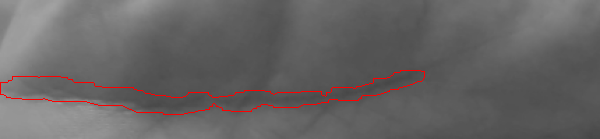

Head line perimeter: 700.88
Head ROI Image:


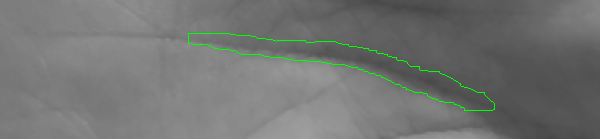

Life line perimeter: 722.84
Life ROI Image:


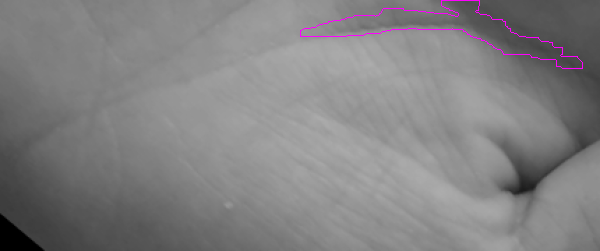

Processing image 4


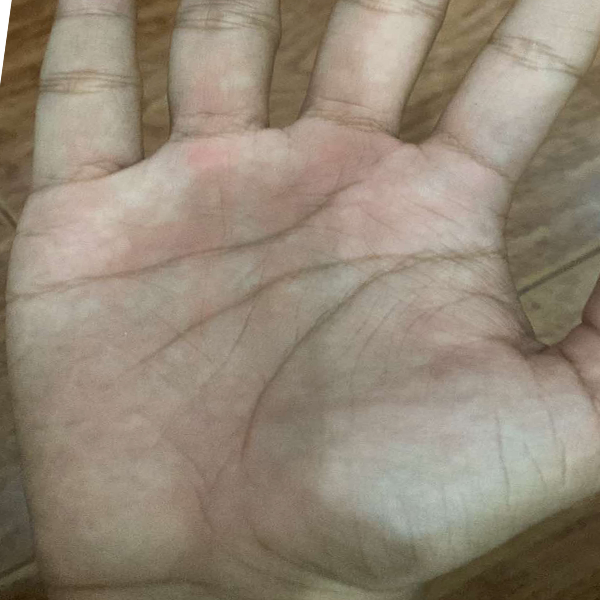

Heart line perimeter: 1154.37
Heart ROI Image:


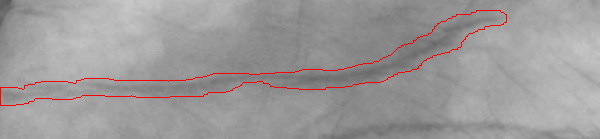

Head line perimeter: 862.23
Head ROI Image:


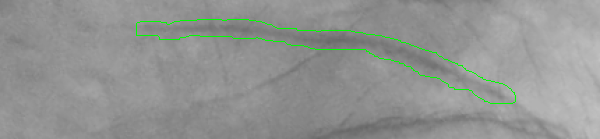

Life line perimeter: 1086.54
Life ROI Image:


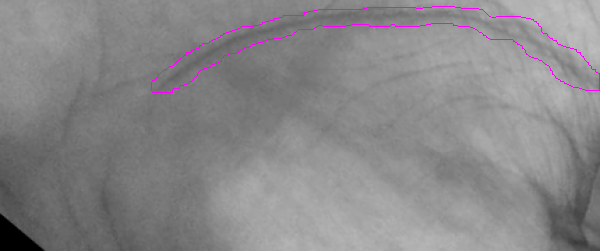

Processing image 5


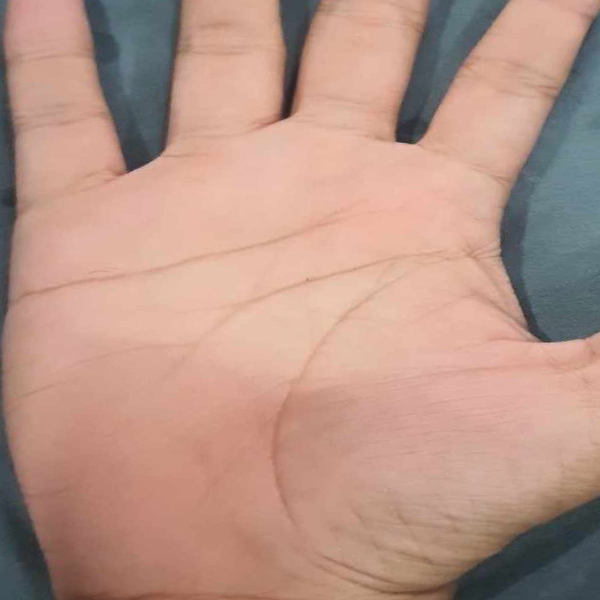

Heart line perimeter: 990.45
Heart ROI Image:


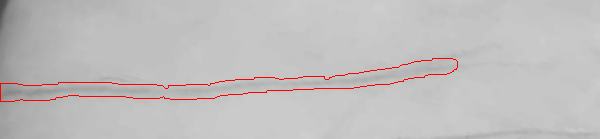

Head line perimeter: 616.29
Head ROI Image:


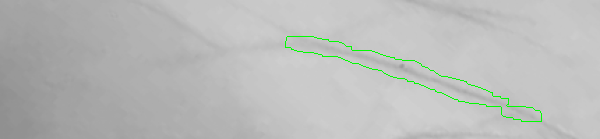

Life line perimeter: 915.39
Life ROI Image:


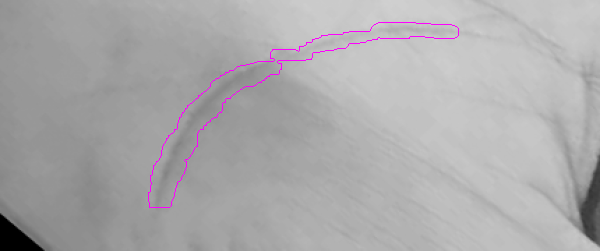

Processing image 6


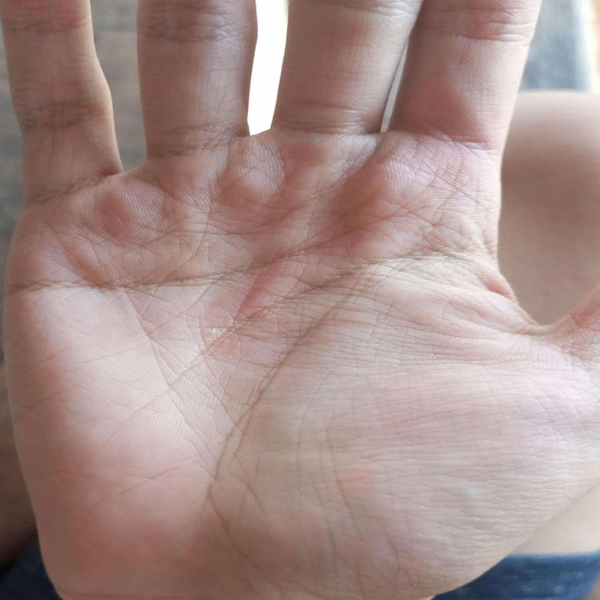

Heart line perimeter: 1491.33
Heart ROI Image:


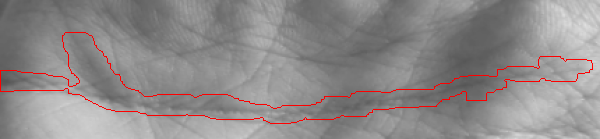

Head line perimeter: 699.56
Head ROI Image:


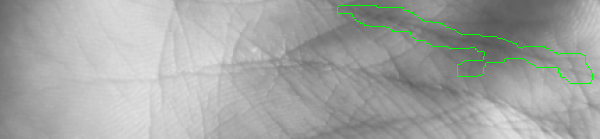

Life line perimeter: 1701.05
Life ROI Image:


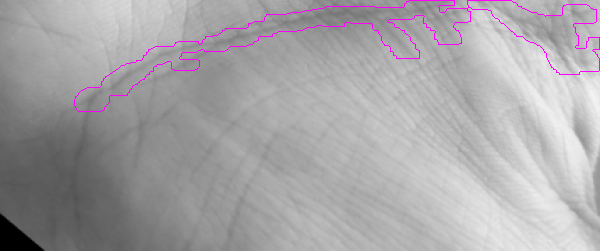

Processing image 7


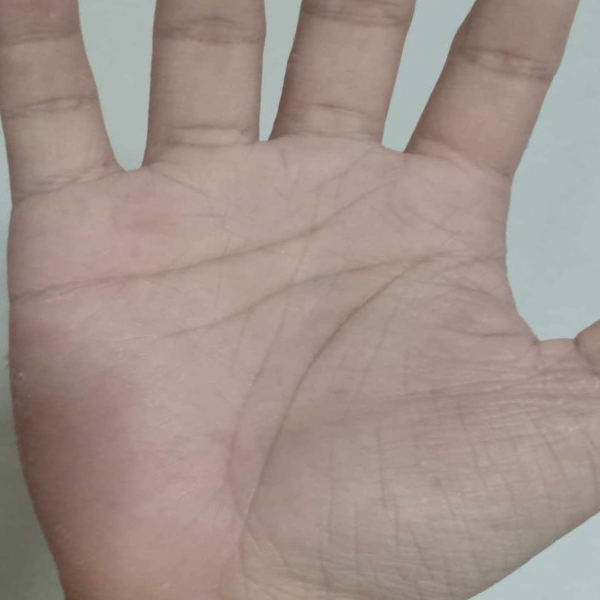

Heart line perimeter: 791.52
Heart ROI Image:


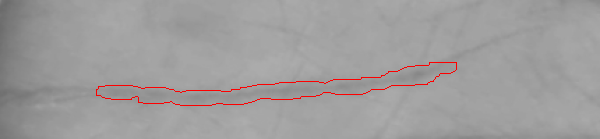

Head line perimeter: 616.79
Head ROI Image:


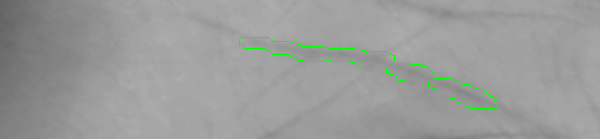

Life line perimeter: 519.10
Life ROI Image:


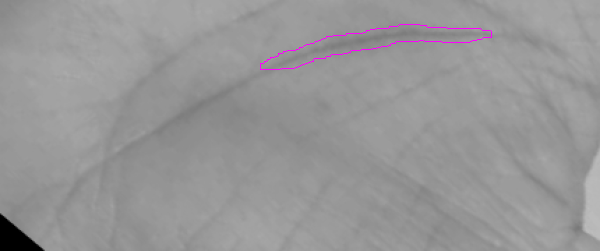

Processing image 8


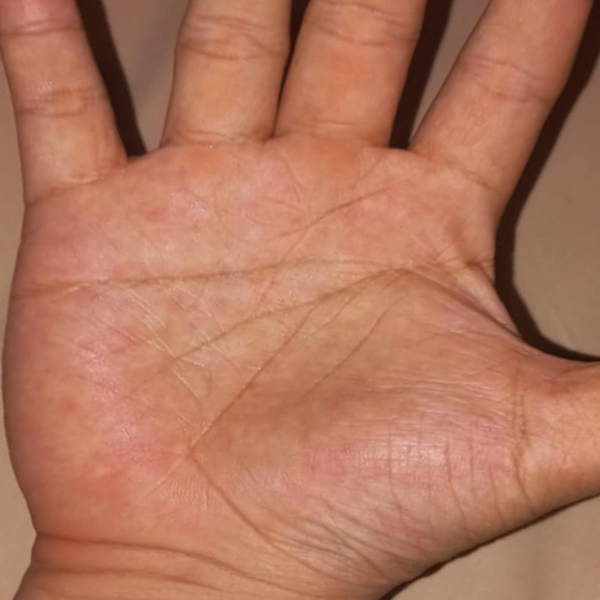

Heart line perimeter: 1042.78
Heart ROI Image:


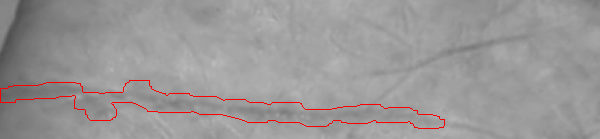

Head line perimeter: 532.65
Head ROI Image:


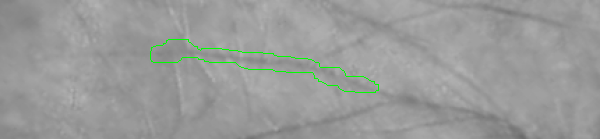

Life line perimeter: 999.59
Life ROI Image:


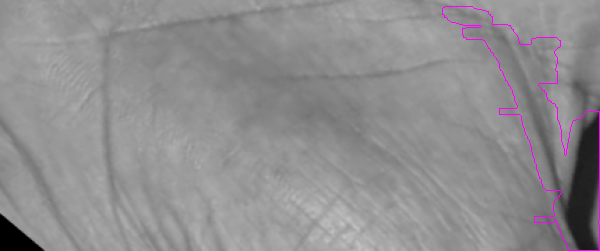

Processing image 9


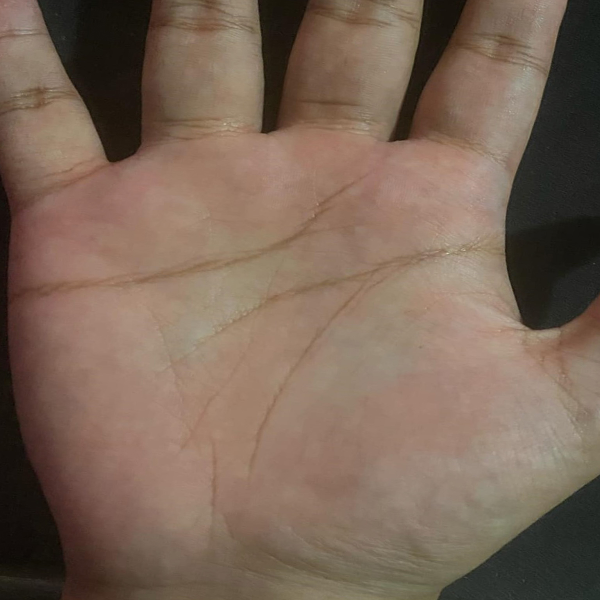

Heart line perimeter: 1129.30
Heart ROI Image:


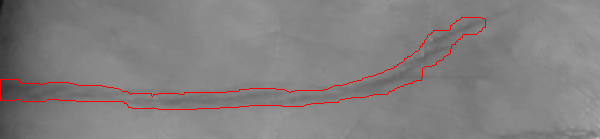

Head line perimeter: 466.17
Head ROI Image:


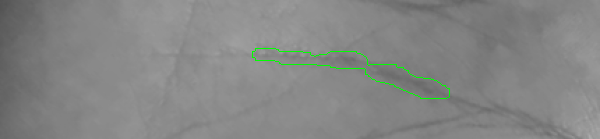

Life line perimeter: 287.54
Life ROI Image:


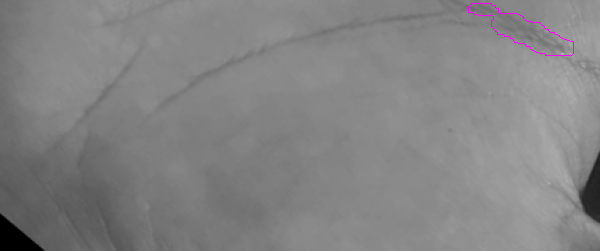

Processing image 10


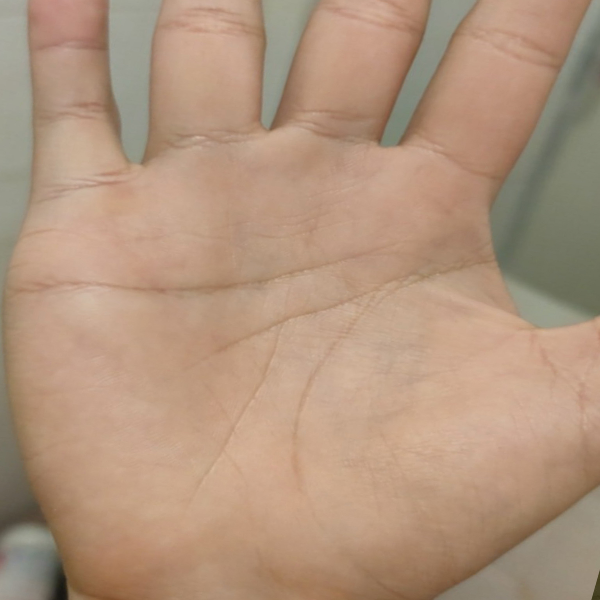

Heart line perimeter: 688.69
Heart ROI Image:


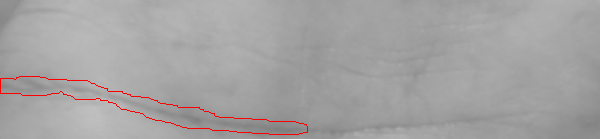

Head line perimeter: 564.01
Head ROI Image:


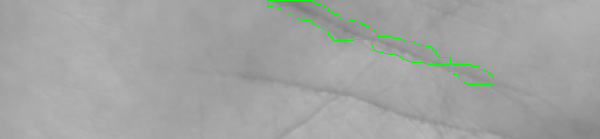

Life line perimeter: 388.79
Life ROI Image:


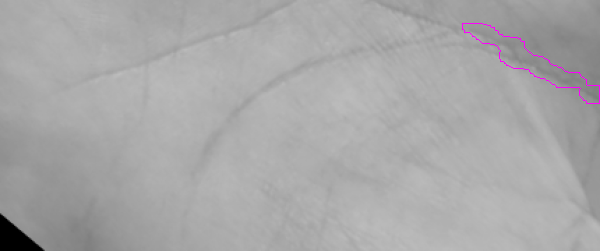

In [ ]:
import cv2
import numpy as np
import os
from google.colab import drive
from google.colab.patches import cv2_imshow

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Set the folder path to your images
image_folder = '/content/drive/My Drive/HW./palmprint_images/palm_refer'  # Update with your folder path

# 3. Load images from the folder
def load_images_from_folder(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            img = cv2.imread(os.path.join(folder_path, filename))
            if img is not None:
                img = cv2.resize(img, (600, 600))
                images.append(img)
    return images

# 4. Function to calculate the length (perimeter) of a contour
def contour_length(contour):
    return cv2.arcLength(contour, True)

# 5. Function to find the longest contour in an image and return its perimeter and contour
def get_longest_contour(thresh_image):
    contours, _ = cv2.findContours(thresh_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    sorted_contours = sorted(contours, key=contour_length, reverse=True)[:1]
    longest_contour = sorted_contours[0] if sorted_contours else None
    perimeter = contour_length(longest_contour) if longest_contour is not None else 0
    return perimeter, longest_contour

# 6. Process a single ROI
def process_roi(roi):
    # Apply Gaussian Blur
    blurred = cv2.GaussianBlur(roi, (35, 35), 0)

    # Apply Adaptive Thresholding
    adaptive_thresh = cv2.adaptiveThreshold(
        blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 29, 2
    )

    # Apply Dilation
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 7))
    dilated = cv2.dilate(adaptive_thresh, kernel, iterations=1)

    # Apply Morphological Opening
    kernel = np.ones((15, 15), np.uint64)
    morph = cv2.morphologyEx(dilated, cv2.MORPH_OPEN, kernel)

    return dilated, morph, roi

# 7. Process the palmprint image
def process_palmprint(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    cv2_imshow(gray)
    gray = cv2.resize(gray, (600, 600))

    # Rotate and define ROIs
    def get_rotated_roi(image, angle, roi_coords):
        center = (image.shape[1] // 2, image.shape[0] // 2)
        rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated_image = cv2.warpAffine(image, rotation_matrix, (image.shape[1], image.shape[0]))
        x, y, w, h = roi_coords
        return rotated_image[y:y+h, x:x+w]

    heart_roi = get_rotated_roi(gray, -10, (25, 180, 440, 100))
    head_roi = get_rotated_roi(gray, -35, (30, 240, 440, 100))
    life_roi = get_rotated_roi(gray, -35, (40, 320, 450, 180))

    # Process each ROI
    dilated_heart, heart_morph, heart_roi = process_roi(heart_roi)
    dilated_head, head_morph, head_roi = process_roi(head_roi)
    dilated_life, life_morph, life_roi = process_roi(life_roi)

    # Get the longest contour and perimeter for each region
    perimeter_heart, longest_contour_heart = get_longest_contour(dilated_heart)
    perimeter_head, longest_contour_head = get_longest_contour(dilated_head)
    perimeter_life, longest_contour_life = get_longest_contour(dilated_life)

    # Draw the longest contours in green (0, 255, 0) on color images
    if longest_contour_heart is not None:
        heart_roi = cv2.cvtColor(heart_roi, cv2.COLOR_GRAY2BGR)
        cv2.drawContours(heart_roi, [longest_contour_heart], -1, (0, 0, 255), 1)

    if longest_contour_head is not None:
        head_roi = cv2.cvtColor(head_roi, cv2.COLOR_GRAY2BGR)  # Convert to BGR
        cv2.drawContours(head_roi, [longest_contour_head], -1, (0, 255, 0), 1)

    if longest_contour_life is not None:
        life_roi = cv2.cvtColor(life_roi, cv2.COLOR_GRAY2BGR)  # Convert to BGR
        cv2.drawContours(life_roi, [longest_contour_life], -1, (255, 0, 255), 1)

    return {
        "heart": (perimeter_heart, longest_contour_heart, heart_roi),
        "head": (perimeter_head, longest_contour_head, head_roi),
        "life": (perimeter_life, longest_contour_life, life_roi),
    }



# 8. Test palmprint pipeline for images in Google Drive
def test_palmprint_pipeline_drive(folder_path):
    # Load all images from the Drive folder
    test_images = load_images_from_folder(folder_path)

    if not test_images:
        print("No images found in the specified folder.")
        return

    for idx, img in enumerate(test_images):
        print(f"Processing image {idx + 1}")
        cv2_imshow(img)  # Display original image

        result = process_palmprint(img)

        for line, (perimeter, contour, roi) in result.items():
            print(f"{line.capitalize()} line perimeter: {perimeter:.2f}")
            print(f"{line.capitalize()} ROI Image:")
            cv2_imshow(roi)  # Show the ROI image with contour drawn

# 9. Run the test
test_palmprint_pipeline_drive(image_folder)